# Telecom RAN Data Generation: Incident Simulation

This notebook demonstrates simulating network incidents for a telecom Radio Access Network (RAN) using Rockfish's Entity Data Generator.

**What this notebook shows:**
- Generating baseline data (normal network operations)
- Generating incident data with degraded parameters (network degradation)
- Concatenating datasets to create continuous timeseries with an incident period
- Visualizing metrics with highlighted incident windows

**Schema comparison:**
- **Baseline schema** (Oct 1, 24 hours): Normal operations
- **Incident schema** (Oct 2, 6 hours): Degraded performance
- Core nodes during the incident: Elevated CPU load, reduced attached UEs
- Cell sites during the incident: Increased connection failures, degraded availability
- Affected entities have the following transport link information: `Device_ID = "RTR_001"`, `Interface_ID = "eth0"`

**Generated data:**
- Baseline: ~9,700 cell site rows (1 day @ 15min)
- Incident: ~500 cell site rows (6 hours @ 15min)
- **Total: ~10,200 cell site rows** with incident period highlighted

## Setup and Imports

In [1]:
import rockfish as rf
import rockfish.actions as ra
import pandas as pd
from dotenv import load_dotenv

from utils import (
    create_telecom_ran_schema,
    create_incident_telecom_ran_schema,
    plot_metric_over_time,
)

In [2]:
# Connect to the Rockfish platform using your API Key
load_dotenv()
conn = rf.Connection.from_env()

## Create Baseline and Incident Schemas

We'll create two `DataSchema` objects:
- **Baseline schema**: Oct 1 (24 hours) - normal network operation
- **Incident schema**: Oct 2 (6 hours) - degraded network performance

For an in-depth explanation of the Rockfish Entity Data Generator and the example schemas used in this tutorial, please refer to [rf_telecom_ran_tutorial.md](rf_telecom_ran_tutorial.md).

In [3]:
# Create the schema instances
telecom_ran_schema = create_telecom_ran_schema(
    global_start_time="2025-10-01T00:00:00Z", 
    global_end_time="2025-10-02T00:00:00Z",
    global_time_interval="15min"
)
incident_ran_schema = create_incident_telecom_ran_schema(
    global_start_time="2025-10-02T00:00:00Z",
    global_end_time="2025-10-02T06:00:00Z",
    global_time_interval="15min"
)

## Run Baseline Data Generation

We'll use a **Rockfish Workflow** to run a data generation job on the Rockfish platform.

See [01_basic_generation.ipynb](01_basic_generation.ipynb) for more information about Rockfish workflows, actions, and action configs.

In [4]:
config = ra.GenerateFromDataSchema.Config(
    schema=telecom_ran_schema,
    upload_datasets=True,
)
generate = ra.GenerateFromDataSchema(config)

In [5]:
builder = rf.WorkflowBuilder()
builder.add(generate)
workflow = await builder.start(conn)
print(f"Workflow ID: {workflow.id()}")
await workflow.wait(raise_on_failure=True)

Workflow ID: SGOdpAW61YNWfd6gSQjR7


In [6]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-11-21T15:30:43.936127Z generate-from-data-schema: INFO Generating 3 entities: transport_link, core_node, cell_site
2025-11-21T15:30:43.945021Z generate-from-data-schema: INFO Starting data generation...
2025-11-21T15:30:44.514972Z generate-from-data-schema: INFO Generated 3 entity tables
2025-11-21T15:30:44.522433Z generate-from-data-schema: INFO Creating dataset for entity 'transport_link': 582 rows
2025-11-21T15:30:44.699161Z generate-from-data-schema: INFO Uploaded dataset 'transport_link' (5PQIZsn7qCTKwiQ994w3H9): 582 rows
2025-11-21T15:30:44.713246Z generate-from-data-schema: INFO Creating dataset for entity 'core_node': 1552 rows
2025-11-21T15:30:44.862356Z generate-from-data-schema: INFO Uploaded dataset 'core_node' (5D237MhltpcYoDuqKSisA6): 1552 rows
2025-11-21T15:30:44.877149Z generate-from-data-schema: INFO Creating dataset for entity 'cell_site': 9700 rows
2025-11-21T15:30:45.043924Z generate-from-data-schema: INFO Uploaded dataset 'cell_site' (5dTNBrh7XGruCAlvHlgu4G): 

## Retrieve Generated Baseline Datasets 

We'll retrieve datasets for `transport_link`, `core_node`, and `cell_site` entities.

In [7]:
datasets = await workflow.datasets().collect()
print(f"Generated {len(datasets)} datasets")

transport_link_dataset = None
core_node_dataset = None
cell_site_dataset = None
for remote_ds in datasets:
    ds = await remote_ds.to_local(conn)
    if ds.name() == "transport_link":
        transport_link_dataset = ds
    elif ds.name() == "core_node":
        core_node_dataset = ds
    elif ds.name() == "cell_site":
        cell_site_dataset = ds

Generated 3 datasets


## Run Incident Data Generation

We'll use a **Rockfish Workflow** to run a data generation job on the Rockfish platform.

See [01_basic_generation.ipynb](01_basic_generation.ipynb) for more information about Rockfish workflows, actions, and action configs.

In [8]:
config = ra.GenerateFromDataSchema.Config(
    schema=incident_ran_schema,
    upload_datasets=True,
)
generate = ra.GenerateFromDataSchema(config)

In [9]:
builder = rf.WorkflowBuilder()
builder.add(generate)
workflow = await builder.start(conn)
print(f"Workflow ID: {workflow.id()}")
await workflow.wait(raise_on_failure=True)

Workflow ID: 4PdteGWPb8dvvBTTBipWPz


In [10]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-11-21T15:30:47.006874Z generate-from-data-schema: INFO Generating 3 entities: transport_link, core_node, cell_site
2025-11-21T15:30:47.014586Z generate-from-data-schema: INFO Starting data generation...
2025-11-21T15:30:47.094109Z generate-from-data-schema: INFO Generated 3 entity tables
2025-11-21T15:30:47.102385Z generate-from-data-schema: INFO Creating dataset for entity 'transport_link': 25 rows
2025-11-21T15:30:47.278288Z generate-from-data-schema: INFO Uploaded dataset 'transport_link' (2o69kbKgDWhzUBBXLXZteC): 25 rows
2025-11-21T15:30:47.291345Z generate-from-data-schema: INFO Creating dataset for entity 'core_node': 150 rows
2025-11-21T15:30:47.440114Z generate-from-data-schema: INFO Uploaded dataset 'core_node' (3E5fvT6114IBaAn5f5N3VR): 150 rows
2025-11-21T15:30:47.454234Z generate-from-data-schema: INFO Creating dataset for entity 'cell_site': 500 rows
2025-11-21T15:30:47.610398Z generate-from-data-schema: INFO Uploaded dataset 'cell_site' (4j8JDYAfFh4BOJY6OeXtYf): 500 r

## Retrieve Generated Incident Datasets 

We'll retrieve datasets for `transport_link`, `core_node`, and `cell_site` entities.

In [11]:
inc_datasets = await workflow.datasets().collect()
print(f"Generated {len(inc_datasets)} datasets")

transport_link_inc_dataset = None
core_node_inc_dataset = None
cell_site_inc_dataset = None
for remote_ds in inc_datasets:
    ds = await remote_ds.to_local(conn)
    if ds.name() == "transport_link":
        transport_link_inc_dataset = ds
    elif ds.name() == "core_node":
        core_node_inc_dataset = ds
    elif ds.name() == "cell_site":
        cell_site_inc_dataset = ds

Generated 3 datasets


## Concatenate Baseline and Incident Data

In the following sections, we'll datasets per entity to create continuous timeseries with an incident period (Oct 2, 00:00 - 06:00). 

We'll then visualize the affected metrics over the full time range (Oct 1 - Oct 2 6am). 

Feel free to reuse the other data exploration code from [01_basic_generation.ipynb](01_basic_generation.ipynb)!

## Inspect Transport Link Data

In this tutorial, we verify that data was generated for transport link. Feel free to reuse the data exploration code from [01_basic_generation.ipynb](01_basic_generation.ipynb)!

In [12]:
transport_link_df = pd.concat([transport_link_dataset.to_pandas(), transport_link_inc_dataset.to_pandas()])
print(f"Transport Link dataset: {len(transport_link_df)} rows")
transport_link_df.head()

Transport Link dataset: 607 rows


,Device_ID,Interface_ID,Bandwidth_Utilization_Out,Packet_Loss_Percent,Latency_ms,Jitter_ms,Timestamp
0,RTR_004,eth1,57.627208,0.387565,15.986711,1.958601,2025-10-01T00:00:00+00:00
1,RTR_004,eth1,56.786161,0.443919,15.780268,1.888845,2025-10-01T00:15:00+00:00
2,RTR_004,eth1,55.739454,0.516126,15.453610,1.849660,2025-10-01T00:30:00+00:00
3,RTR_004,eth1,51.060260,0.471744,15.776317,1.964455,2025-10-01T00:45:00+00:00
4,RTR_004,eth1,51.271135,0.398359,15.292285,2.151212,2025-10-01T01:00:00+00:00


## Visualize Core Node Metrics with the Incident

The red highlighted region in each plot shows the 6-hour incident window with degraded performance.

In [13]:
core_node_df = pd.concat([core_node_dataset.to_pandas(), core_node_inc_dataset.to_pandas()])
print(f"Core Node dataset: {len(core_node_df)} rows")
core_node_df.head()

Core Node dataset: 1702 rows


,Core_Node_ID,MM_AttachedUEs,SM_ActivePDUSessions,CPU_Load,Timestamp
0,MME_001,5310,3068,62.167676,2025-10-01T00:00:00+00:00
1,MME_001,5252,3145,59.791042,2025-10-01T00:15:00+00:00
2,MME_001,5248,3153,58.520525,2025-10-01T00:30:00+00:00
3,MME_001,4960,3037,58.282711,2025-10-01T00:45:00+00:00
4,MME_001,5080,2863,53.845959,2025-10-01T01:00:00+00:00


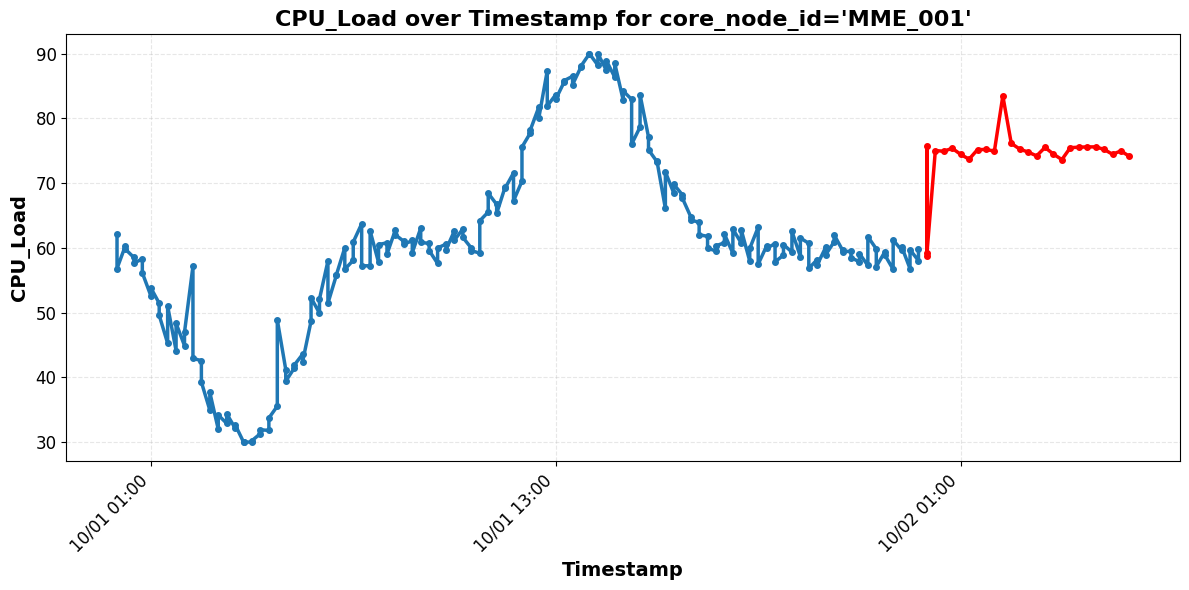

In [14]:
core_node_id = "MME_001"
ts = "Timestamp"
df = core_node_df[core_node_df["Core_Node_ID"] == core_node_id]
for col in ["CPU_Load"]:
    plot_metric_over_time(
        df,
        metric_col=col,
        timestamp_col=ts,
        title=f"{col} over {ts} for {core_node_id=}",
        highlight_start="2025-10-02T00:00:00Z",
        highlight_end="2025-10-02T06:00:00Z",
    )

## Visualize Cell Site Metrics with the Incident

The red highlighted region in each plot shows the 6-hour incident window with degraded performance.

In [15]:
cell_site_df = pd.concat([cell_site_dataset.to_pandas(), cell_site_inc_dataset.to_pandas()])
print(f"Cell Site dataset: {len(cell_site_df)} rows")
cell_site_df.head()

Cell Site dataset: 10200 rows


,Cell_ID,Base_Station_ID,Location_Lat,Location_Lon,Transport_Device_ID,Transport_Interface_ID,RRC_ConnEstabFail,RRC_ConnEstabSucc,RRC_ConnEstabAtt,ERAB_EstabInitSuccNbr_QCI,DL_PRB_Utilization,Cell_Availability,Timestamp
0,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,92,102,94.291707,51.213983,99.493276,2025-10-01T00:00:00+00:00
1,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,96,106,93.241803,52.994845,99.484967,2025-10-01T00:15:00+00:00
2,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,8,91,100,91.981074,51.790901,99.495991,2025-10-01T00:30:00+00:00
3,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,91,100,90.071331,51.306298,99.531170,2025-10-01T00:45:00+00:00
4,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,7,92,100,86.199011,49.888713,99.540730,2025-10-01T01:00:00+00:00


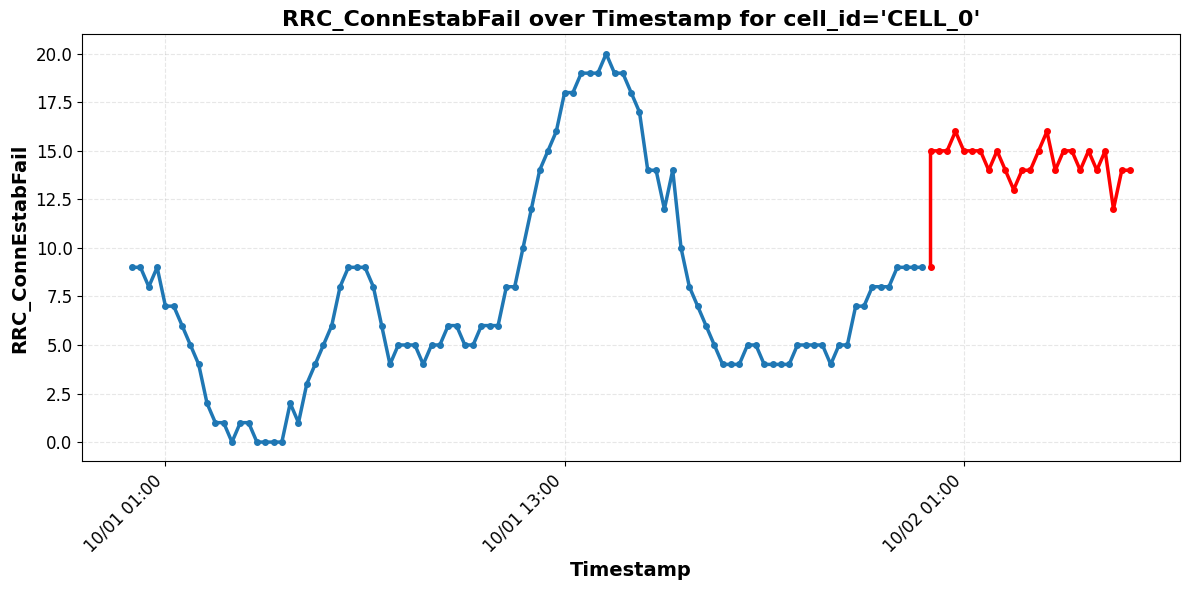

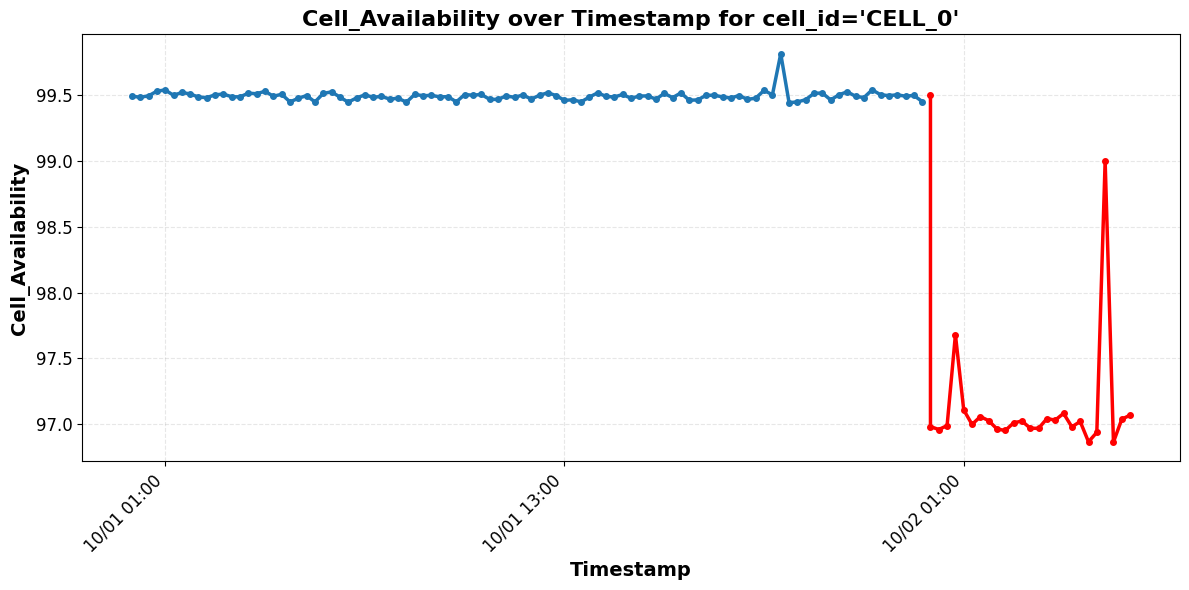

In [16]:
cell_id = "CELL_0"
ts = "Timestamp"
df = cell_site_df[cell_site_df["Cell_ID"] == cell_id]
for col in [
    "RRC_ConnEstabFail",
    "Cell_Availability",
]:
    plot_metric_over_time(
        df, 
        metric_col=col, 
        timestamp_col=ts, 
        title=f"{col} over {ts} for {cell_id=}",
        highlight_start="2025-10-02T00:00:00Z",
        highlight_end="2025-10-02T06:00:00Z",
    )

## Save Data to CSV

In [17]:
# Save all datasets to file
transport_link_df.to_csv("transport_link_data_incident.csv", index=False)
core_node_df.to_csv("core_node_data_incident.csv", index=False)
cell_site_df.to_csv("cell_site_data_incident.csv", index=False)